<a href="https://colab.research.google.com/github/nik-o-o/movie-recommender/blob/main/movie_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INTRODUCTION

This is a recommendation engine for movies for users based on their past behaviour.

Approach used : Collaborative Filtering, that is:
                The user is recommended items that people with similar tastes and preferences liked in the past. In another words, this method predicts unknown ratings by using the similarities between the users.

# Packages Used:
- pandas
- matplotlib
- numpy
- scikit-surprise

In [1]:
print('>> Installing Libraries.')
!pip3 install pandas matplotlib numpy scikit-surprise
print('>> Libraries Installed.')

>> Installing Libraries.
     |████████████████████████████████| 11.8MB 4.2MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1670920 sha256=713d72d686b6856a9bb3f725f405b46100af24a3c4d4f1cf25f69f111fc16386
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise
>> Libraries Installed.


In [2]:
print('>> Importing Libraries...')

import pandas as pd
from surprise import Reader, Dataset, SVD
from surprise.accuracy import rmse, mae
from surprise.model_selection import cross_validate

print('>> Libraries Imported.')

>> Importing Libraries...
>> Libraries Imported.


# Importing Data
The open-source dataset is taken from  GroupLens Research (movielens.org)

In [24]:
df = pd.read_csv('ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [25]:
# Dropping the 'timestamp' column as it is not needed.
df.drop('timestamp', axis = 1, inplace = True) # inplace => dropping will take place in the same df. No new df will be created or returned.
df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [27]:
# Checking for Missing Data
df.isna().sum()

userId     0
movieId    0
rating     0
dtype: int64

# EDA (Exploratory Data Analysis)

In [28]:
# Number of Movies/Users
n_movies = df["movieId"].nunique()
n_users = df["userId"].nunique()
print(f'Number of unique movies = {n_movies}')
print(f'Number of unique users = {n_users}')

Number of unique movies = 9724
Number of unique users = 610


### Sparsity of Data
`sparsity(%) = (No of missing values/ (Total values)) * 100`

In [30]:
available_ratings = df['rating'].count()
total_ratings = n_movies * n_users
missing_ratings = total_ratings - available_ratings
sparsity = (missing_ratings / total_ratings) * 100
print(f'sparsity = {sparsity}')

sparsity = 98.30003169443864


### Rating Distribution

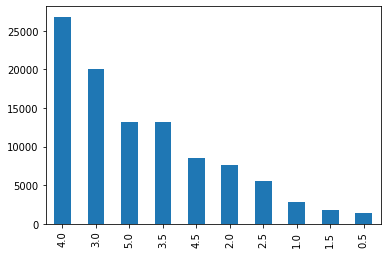

In [31]:
df['rating'].value_counts().plot(kind = 'bar')

# Dimensionality Reduction
To reduce the dimensionality of the dataset, filter out rarely rated movies and rarely rating users

### Filter movies with less than 3 ratings

In [33]:
filter_movies = df['movieId'].value_counts() > 3
filter_movies = filter_movies[filter_movies].index.to_list()

### Filter users with less than 3 movies rated

In [34]:
filter_users = df['userId'].value_counts() > 3
filter_users = filter_users[filter_users].index.to_list()

### Remove rarely rated movies and rarely rating users

In [35]:
print(f'Original shape : {df.shape}')
df = df[(df['movieId'].isin(filter_movies)) & (df['userId'].isin(filter_users))]
print(f'New shape : {df.shape}')

Original shape : (100836, 3)
New shape : (92394, 3)


# Creating Training and Test sets

In [42]:
cols = ['userId', 'movieId', 'rating']

# surprise dataset
reader = Reader(rating_scale = (0.5, 5))
data = Dataset.load_from_df(df[cols], reader)

# trainset and prediction set
trainset = data.build_full_trainset()
antiset = trainset.build_anti_testset()

# Creating and Training the Model


### Creating the Model
SVD (Singular Value Decomposition)

In [43]:
algo = SVD(n_epochs = 5, verbose = True)


### Training the model
Mean Absolute Error (MAE): MAE measures the average magnitudeof the errors in a set of predictions, without considering direction.

Root Mean Squared Error (RMSE): RMSE is the squared root of the average of the squeared differences between prediction and observation.

In [44]:
cross_validate(algo, data, measures = ['rmse', 'mae'], cv = 5, verbose = True)
print('>> Training Done.')

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8889  0.8788  0.8765  0.8884  0.8842  0.8834  0.0050  
MAE (testset)     0.6878  0.6825  0.6761  0.6849  0.6821  0.6827  0.0039  
Fit time          1.30    1.29    1.32    1.31    1.30    1.31    0.01    
Test time         0.28    0.15    0.27    0.13    0.27    0.22    0.06    
>> Training Done.


# Predictions

In [45]:
predictions = algo.test(antiset)

In [46]:
predictions[0]

Prediction(uid=1, iid=318, r_ui=3.529119856267723, est=4.986374271166494, details={'was_impossible': False})

## Recommending top 3 Movies based on predictions

In [47]:
from collections import defaultdict

def get_top_n(predictions, n):
  top_n = defaultdict(list)
  
  for uid, iid, _, est, _ in predictions:
    top_n[uid].append((iid, est))
  
  for uid, user_ratings in top_n.items():
    user_ratings.sort(key = lambda x: x[1], reverse = True)
    top_n[uid] = user_ratings[:n]

  return top_n

top_n = get_top_n(predictions, n = 3)

In [52]:
for uid, user_ratings in top_n.items():
  print("UserId " + str(uid) + " should watch MovieIds : " + str([iid for (iid, rating) in user_ratings]))

UserId 1 should watch MovieIds : [318, 58559, 750]
UserId 2 should watch MovieIds : [1089, 858, 1213]
UserId 3 should watch MovieIds : [858, 318, 7361]
UserId 4 should watch MovieIds : [318, 48516, 356]
UserId 5 should watch MovieIds : [2959, 1617, 750]
UserId 6 should watch MovieIds : [2329, 1221, 858]
UserId 7 should watch MovieIds : [318, 1198, 2329]
UserId 8 should watch MovieIds : [912, 1136, 2959]
UserId 9 should watch MovieIds : [2959, 318, 2329]
UserId 10 should watch MovieIds : [50, 318, 7361]
UserId 11 should watch MovieIds : [7361, 50, 48516]
UserId 12 should watch MovieIds : [2959, 58559, 858]
UserId 13 should watch MovieIds : [858, 5618, 904]
UserId 14 should watch MovieIds : [858, 1089, 50]
UserId 15 should watch MovieIds : [50, 1193, 48516]
UserId 16 should watch MovieIds : [48516, 1288, 1259]
UserId 17 should watch MovieIds : [912, 1028, 608]
UserId 18 should watch MovieIds : [750, 2858, 1204]
UserId 19 should watch MovieIds : [318, 858, 50]
UserId 20 should watch Movie